In [113]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd
from sklearn.metrics import mean_squared_error
import itertools
from tqdm import tqdm

# SARIMA model
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# LSTM
# import tensorflow as tf
# from tensorflow.keras.models import Sequential, load_model
# from tensorflow.keras.layers import LSTM, Dense, Dropout
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler

# Seq2seq
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping

In [2]:
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)

In [3]:
# Prédire février 2005 et mars 2005. Entraîner de février 2003 à janvien 2005
df = pd.concat([pd.read_parquet('data/tec_2003.parquet.gzip'), pd.read_parquet('data/tec_2004.parquet.gzip'), pd.read_parquet('data/tec_2005.parquet.gzip')])
df

,time,gdlat,glon,tec,datetime,year,month,day,hour,minute,second
3570,1.041379e+09,59.0,136.0,10.7,2003-01-01 00:02:30,2003,1,1,0,2,30
3571,1.041379e+09,59.0,137.0,10.6,2003-01-01 00:02:30,2003,1,1,0,2,30
3613,1.041379e+09,60.0,143.0,10.0,2003-01-01 00:02:30,2003,1,1,0,2,30
3679,1.041379e+09,62.0,134.0,7.0,2003-01-01 00:02:30,2003,1,1,0,2,30
7679,1.041380e+09,59.0,136.0,10.7,2003-01-01 00:07:30,2003,1,1,0,7,30
...,...,...,...,...,...,...,...,...,...,...,...
21918479,1.136073e+09,59.0,140.0,7.5,2005-12-31 23:52:30,2005,12,31,23,52,30
21918600,1.136073e+09,62.0,141.0,5.3,2005-12-31 23:52:30,2005,12,31,23,52,30
21923482,1.136073e+09,58.0,139.0,8.2,2005-12-31 23:57:30,2005,12,31,23,57,30
21923483,1.136073e+09,58.0,140.0,7.9,2005-12-31 23:57:30,2005,12,31,23,57,30


### Manipulation de données

In [4]:
df_siberia = df [(df['gdlat'] >= 56.0) & (df['gdlat'] <= 58.0) & (df['glon'] >= 136.0) & (df['glon'] <= 140.0)].copy()
pd.crosstab(df_siberia['gdlat'], df_siberia['glon'])

glon,136.0,137.0,138.0,139.0,140.0
gdlat,,,,,
56.0,8008,3631,10095,10765,6802
57.0,4801,14876,14334,8717,12331
58.0,10427,11329,11175,14757,14797


In [5]:
def equilibrate_regions(df):
    duplicate = np.max(pd.crosstab(df['gdlat'], df['glon'])) // pd.crosstab(df['gdlat'], df['glon']) - 1
    sample = np.max(pd.crosstab(df['gdlat'], df['glon'])) % pd.crosstab(df['gdlat'], df['glon'])
    for gdlat in duplicate.index:
        for glon in duplicate.columns:
            # Duplicate
            df_lat_lon = df[ (df['gdlat'] == gdlat) & (df['glon'] == glon) ].reset_index(drop=True)
            add = [df_lat_lon]*duplicate.loc[gdlat, glon]
            # Sample
            sampled_indices = np.random.choice(df_lat_lon.index, size=sample.loc[gdlat, glon], replace=False)
            add.append(df_lat_lon.loc[sampled_indices, :])
            # Add new rows
            if add:
                add = pd.concat(add)
                df = pd.concat([df, add]).reset_index(drop=True)
    return df.sort_values(by='datetime').reset_index(drop=True)

In [6]:
df_siberia_equilibrate = equilibrate_regions(df_siberia)
pd.crosstab(df_siberia_equilibrate['gdlat'], df_siberia_equilibrate['glon'])

glon,136.0,137.0,138.0,139.0,140.0
gdlat,,,,,
56.0,14876,14876,14876,14876,14876
57.0,14876,14876,14876,14876,14876
58.0,14876,14876,14876,14876,14876


In [7]:
def average_by_2hourly_bin(df, datetime_col, measure_col):
    """
    Average values within 2-hour bins.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe containing datetime and measure columns
    datetime_col : str
        Name of the datetime column
    measure_col : str
        Name of the measure column
    
    Returns:
    --------
    pandas.DataFrame
        Dataframe with 2-hourly timestamps and averaged values
    """
    df = df.copy()
    
    # Create regular 2-hourly time index
    start_time = df[datetime_col].min().floor('2h')
    end_time = df[datetime_col].max().ceil('2h')
    two_hourly_index = pd.date_range(start=start_time, end=end_time, freq='2h')
    
    # Bin data into 2-hour intervals and calculate mean
    df[datetime_col] = pd.to_datetime(df[datetime_col]).dt.floor('2h')
    result = df.groupby(datetime_col)[measure_col].mean().reindex(two_hourly_index)
    
    # Convert to dataframe
    result_df = result.reset_index()
    result_df.columns = [datetime_col, measure_col]
    
    return result_df

In [8]:
df_siberia_equilibrate_2hourly = average_by_2hourly_bin(df_siberia_equilibrate, 'datetime', 'tec')
df_siberia_equilibrate_2hourly

,datetime,tec
0,2003-01-01 00:00:00,13.500000
1,2003-01-01 02:00:00,16.748276
2,2003-01-01 04:00:00,14.146154
3,2003-01-01 06:00:00,10.366667
4,2003-01-01 08:00:00,NaN
...,...,...
13148,2005-12-31 16:00:00,5.057143
13149,2005-12-31 18:00:00,NaN
13150,2005-12-31 20:00:00,5.081818
13151,2005-12-31 22:00:00,7.966667


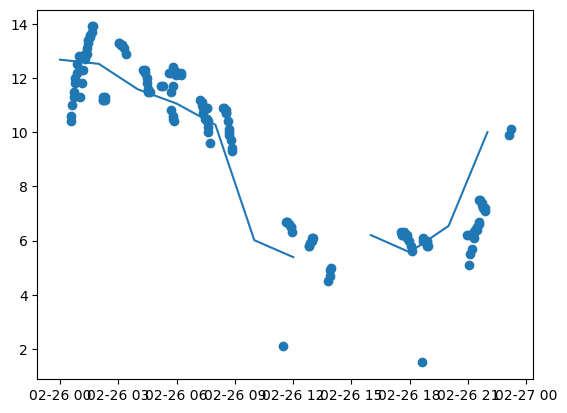

In [9]:
plt.scatter(df_siberia['datetime'][(df_siberia['datetime'] >= '2005-02-26') & (df_siberia['datetime'] < '2005-02-27')] , df_siberia['tec'][(df_siberia['datetime'] >= '2005-02-26') & (df_siberia['datetime'] < '2005-02-27')] )
plt.plot(df_siberia_equilibrate_2hourly['datetime'][(df_siberia_equilibrate_2hourly['datetime'] >= '2005-02-26') & (df_siberia_equilibrate_2hourly['datetime'] < '2005-02-27')] , df_siberia_equilibrate_2hourly['tec'][(df_siberia_equilibrate_2hourly['datetime'] >= '2005-02-26') & (df_siberia_equilibrate_2hourly['datetime'] < '2005-02-27')] )


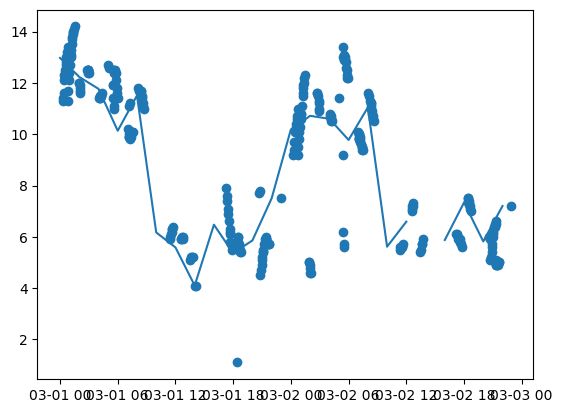

In [10]:
plt.scatter(df_siberia['datetime'][(df_siberia['datetime'] >= '2005-03-01') & (df_siberia['datetime'] < '2005-03-03')] , df_siberia['tec'][(df_siberia['datetime'] >= '2005-03-01') & (df_siberia['datetime'] < '2005-03-03')] )
plt.plot(df_siberia_equilibrate_2hourly['datetime'][(df_siberia_equilibrate_2hourly['datetime'] >= '2005-03-01') & (df_siberia_equilibrate_2hourly['datetime'] < '2005-03-03')] , df_siberia_equilibrate_2hourly['tec'][(df_siberia_equilibrate_2hourly['datetime'] >= '2005-03-01') & (df_siberia_equilibrate_2hourly['datetime'] < '2005-03-03')] )


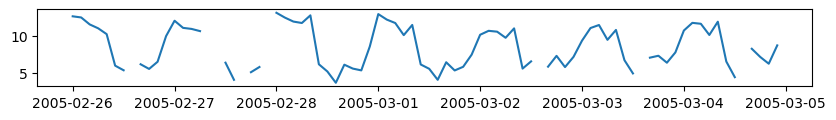

In [11]:
plt.figure(figsize=(10, 1))
plt.plot(df_siberia_equilibrate_2hourly['datetime'][(df_siberia_equilibrate_2hourly['datetime'] >= '2005-02-26') & (df_siberia_equilibrate_2hourly['datetime'] < '2005-03-05')] , df_siberia_equilibrate_2hourly['tec'][(df_siberia_equilibrate_2hourly['datetime'] >= '2005-02-26') & (df_siberia_equilibrate_2hourly['datetime'] < '2005-03-05')] )


In [12]:
df_siberia_equilibrate_2hourly = df_siberia_equilibrate_2hourly.set_index('datetime')
df_siberia_equilibrate_2hourly_linear = df_siberia_equilibrate_2hourly.interpolate(method='linear')
df_siberia_equilibrate_2hourly_linear = df_siberia_equilibrate_2hourly_linear.reset_index()
df_siberia_equilibrate_2hourly_linear

,datetime,tec
0,2003-01-01 00:00:00,13.500000
1,2003-01-01 02:00:00,16.748276
2,2003-01-01 04:00:00,14.146154
3,2003-01-01 06:00:00,10.366667
4,2003-01-01 08:00:00,7.562281
...,...,...
13148,2005-12-31 16:00:00,5.057143
13149,2005-12-31 18:00:00,5.069481
13150,2005-12-31 20:00:00,5.081818
13151,2005-12-31 22:00:00,7.966667


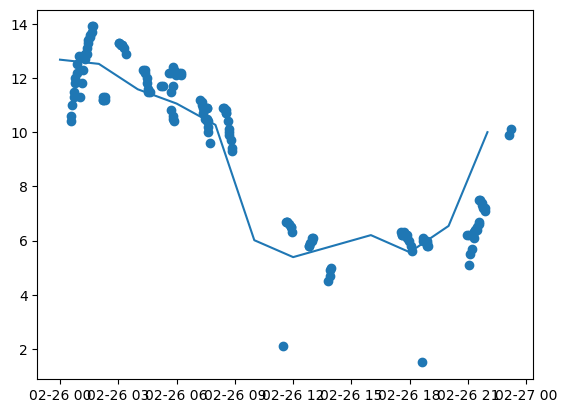

In [13]:
plt.scatter(df_siberia['datetime'][(df_siberia['datetime'] >= '2005-02-26') & (df_siberia['datetime'] < '2005-02-27')] , df_siberia['tec'][(df_siberia['datetime'] >= '2005-02-26') & (df_siberia['datetime'] < '2005-02-27')] )
plt.plot(df_siberia_equilibrate_2hourly_linear['datetime'][(df_siberia_equilibrate_2hourly_linear['datetime'] >= '2005-02-26') & (df_siberia_equilibrate_2hourly_linear['datetime'] < '2005-02-27')] , df_siberia_equilibrate_2hourly_linear['tec'][(df_siberia_equilibrate_2hourly_linear['datetime'] >= '2005-02-26') & (df_siberia_equilibrate_2hourly_linear['datetime'] < '2005-02-27')] )


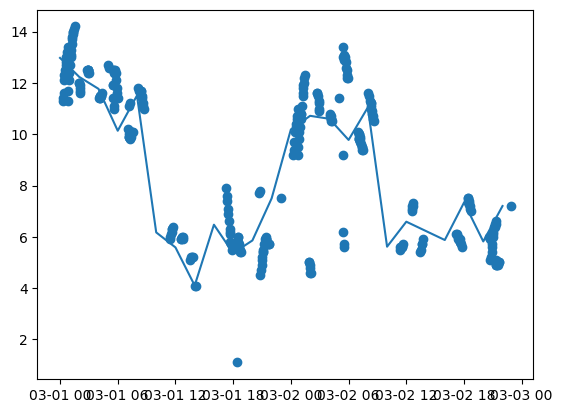

In [14]:
plt.scatter(df_siberia['datetime'][(df_siberia['datetime'] >= '2005-03-01') & (df_siberia['datetime'] < '2005-03-03')] , df_siberia['tec'][(df_siberia['datetime'] >= '2005-03-01') & (df_siberia['datetime'] < '2005-03-03')] )
plt.plot(df_siberia_equilibrate_2hourly_linear['datetime'][(df_siberia_equilibrate_2hourly_linear['datetime'] >= '2005-03-01') & (df_siberia_equilibrate_2hourly_linear['datetime'] < '2005-03-03')] , df_siberia_equilibrate_2hourly_linear['tec'][(df_siberia_equilibrate_2hourly_linear['datetime'] >= '2005-03-01') & (df_siberia_equilibrate_2hourly_linear['datetime'] < '2005-03-03')] )


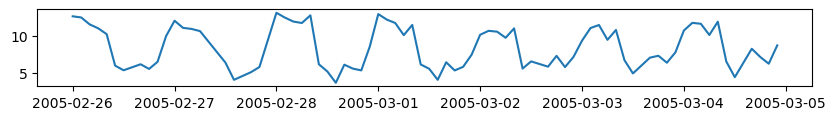

In [15]:
plt.figure(figsize=(10, 1))
plt.plot(df_siberia_equilibrate_2hourly_linear['datetime'][(df_siberia_equilibrate_2hourly_linear['datetime'] >= '2005-02-26') & (df_siberia_equilibrate_2hourly_linear['datetime'] < '2005-03-05')] , df_siberia_equilibrate_2hourly_linear['tec'][(df_siberia_equilibrate_2hourly_linear['datetime'] >= '2005-02-26') & (df_siberia_equilibrate_2hourly_linear['datetime'] < '2005-03-05')] )


In [16]:
def create_trajectory_matrix(time_series, window):
    """
    Create trajectory matrix from time series using sliding window.
    
    Args:
        time_series (array-like): Input time series
        window (int): Window size
        
    Returns:
        np.ndarray: Trajectory matrix
    """
    n = len(time_series)
    k = n - window + 1
    matrix = np.zeros((k, window))
    
    for i in range(k):
        matrix[i, :] = time_series[i:i + window]
        
    return matrix

In [21]:
X = create_trajectory_matrix(df_siberia_equilibrate_2hourly_linear['tec'], 84) # 12*7 = 84 observations in a week
s = svd(X, full_matrices=False, compute_uv=False)
s / s.sum()

array([0.32704775, 0.07000925, 0.06993832, 0.0273867 , 0.02697353,
       0.02630944, 0.0180487 , 0.01482299, 0.01299405, 0.01193098,
       0.01129323, 0.01103939, 0.01096433, 0.01049279, 0.01045619,
       0.01042943, 0.01041031, 0.01008823, 0.00955839, 0.00930692,
       0.00893857, 0.00877044, 0.00844571, 0.00805278, 0.0076783 ,
       0.00765219, 0.00709891, 0.00676284, 0.00651319, 0.00636917,
       0.00602389, 0.0057664 , 0.00575016, 0.00561352, 0.0054906 ,
       0.00545401, 0.00531956, 0.00531648, 0.00524461, 0.00503302,
       0.00489609, 0.00484899, 0.00469397, 0.00463188, 0.00457317,
       0.00435391, 0.00425971, 0.004203  , 0.00411919, 0.00409866,
       0.00405511, 0.00405411, 0.00394827, 0.0039324 , 0.00390971,
       0.00390033, 0.00388631, 0.00383896, 0.00381708, 0.00377705,
       0.00377488, 0.00373638, 0.00372762, 0.00372039, 0.00362303,
       0.00351737, 0.00345783, 0.0034511 , 0.00337517, 0.00325795,
       0.00312055, 0.00301686, 0.00296447, 0.00296268, 0.00292

In [27]:
np.cumsum(s / s.sum())[24]

np.float64(0.7513867352502754)

In [28]:
def low_rank_interpolate(X, W, K, max_iter=100, tol=1e-6):
    """
    Interpolate missing values in trajectory matrix using low rank approximation.
    
    Args:
        X (np.ndarray): Trajectory matrix with missing values
        W (np.ndarray): Mask matrix (1 for observed, 0 for missing)
        K (int): Expected rank
        max_iter (int): Maximum iterations
        tol (float): Convergence tolerance
        
    Returns:
        np.ndarray: Interpolated trajectory matrix
    """
    X_hat = np.zeros_like(X)
    X_hat[W == 0] = np.mean(X[W == 1])  # Initialize missing values with mean
    
    prev_norm = np.inf
    for _ in tqdm(range(max_iter)):
        # Combine observed values from X and interpolated values from X_hat
        Y = X + X_hat * (1 - W)
        
        # SVD computation
        U, s, Vt = svd(Y, full_matrices=False)
        
        # Low rank approximation
        X_hat = sum(s[k] * np.outer(U[:, k], Vt[k, :]) for k in range(min(K, len(s))))
        
        # Check convergence
        current_norm = np.linalg.norm(X_hat * (1 - W))
        if abs(current_norm - prev_norm) < tol:
            break
        prev_norm = current_norm
        
    return X_hat


In [30]:
X = create_trajectory_matrix(df_siberia_equilibrate_2hourly['tec'].to_numpy(), 84)
X

array([[13.5       , 16.74827586, 14.14615385, ...,  6.68636364,
                nan, 11.05      ],
       [16.74827586, 14.14615385, 10.36666667, ...,         nan,
        11.05      , 20.33333333],
       [14.14615385, 10.36666667,         nan, ..., 11.05      ,
        20.33333333, 25.96551724],
       ...,
       [ 3.19      ,  7.30588235,  9.2       , ...,  5.05714286,
                nan,  5.08181818],
       [ 7.30588235,  9.2       ,  7.16      , ...,         nan,
         5.08181818,  7.96666667],
       [ 9.2       ,  7.16      ,  4.83333333, ...,  5.08181818,
         7.96666667,         nan]], shape=(13070, 84))

In [31]:
W = (~np.isnan(X)).astype(int)
W

array([[1, 1, 1, ..., 1, 0, 1],
       [1, 1, 1, ..., 0, 1, 1],
       [1, 1, 0, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 0, 1],
       [1, 1, 1, ..., 0, 1, 1],
       [1, 1, 1, ..., 1, 1, 0]], shape=(13070, 84))

In [32]:
X = np.nan_to_num(X)
X

array([[13.5       , 16.74827586, 14.14615385, ...,  6.68636364,
         0.        , 11.05      ],
       [16.74827586, 14.14615385, 10.36666667, ...,  0.        ,
        11.05      , 20.33333333],
       [14.14615385, 10.36666667,  0.        , ..., 11.05      ,
        20.33333333, 25.96551724],
       ...,
       [ 3.19      ,  7.30588235,  9.2       , ...,  5.05714286,
         0.        ,  5.08181818],
       [ 7.30588235,  9.2       ,  7.16      , ...,  0.        ,
         5.08181818,  7.96666667],
       [ 9.2       ,  7.16      ,  4.83333333, ...,  5.08181818,
         7.96666667,  0.        ]], shape=(13070, 84))

In [33]:
estimated_trajectory_matrix = low_rank_interpolate(X, W, 24) # keep first 24 singular values 
estimated_trajectory_matrix

100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


array([[13.8834344 , 17.6132694 , 14.77609748, ...,  7.0761704 ,
        13.39571987, 11.94880876],
       [18.04272409, 14.4746381 ,  9.31678469, ..., 10.52838881,
        13.37697868, 19.66451125],
       [15.84008216,  9.97983722,  2.07252448, ..., 13.14261225,
        20.46040091, 25.00704192],
       ...,
       [ 2.88814465,  7.34176855,  9.26986664, ...,  4.72985691,
        10.27203492,  4.83324863],
       [ 7.36650274,  9.1010389 ,  6.88358213, ..., 13.01471603,
         6.01049692,  6.63407822],
       [ 9.31088011,  6.83314809,  5.02665974, ...,  6.05413147,
         7.01605536, 11.08444641]], shape=(13070, 84))

In [34]:
def recover_time_series(trajectory_matrix):
    """
    Recover original time series from trajectory matrix using diagonal averaging.
    
    Args:
        trajectory_matrix (np.ndarray): Matrix of shape (n - window_size + 1, window_size)
    
    Returns:
        np.ndarray: Recovered time series of length n
    """
    L = trajectory_matrix.shape[1]  # window_size
    K = trajectory_matrix.shape[0]  # n - window_size + 1
    n = L + K - 1  # original series length
    
    recovered = np.zeros(n)
    counts = np.zeros(n)
    
    # Fill the recovered series using diagonal averaging
    for i in range(K):
        for j in range(L):
            recovered[i + j] += trajectory_matrix[i, j]
            counts[i + j] += 1
            
    # Normalize by the number of elements in each diagonal
    recovered = recovered / counts
    
    return recovered

In [35]:
df_siberia_equilibrate_2hourly_low_rank = pd.DataFrame(recover_time_series(estimated_trajectory_matrix), columns=['tec'], index=df_siberia_equilibrate_2hourly.index)
df_siberia_equilibrate_2hourly_low_rank

,tec
datetime,
2003-01-01 00:00:00,13.883434
2003-01-01 02:00:00,17.827997
2003-01-01 04:00:00,15.030273
2003-01-01 06:00:00,10.014589
2003-01-01 08:00:00,2.422476
...,...
2005-12-31 16:00:00,4.629334
2005-12-31 18:00:00,10.968287
2005-12-31 20:00:00,5.632626


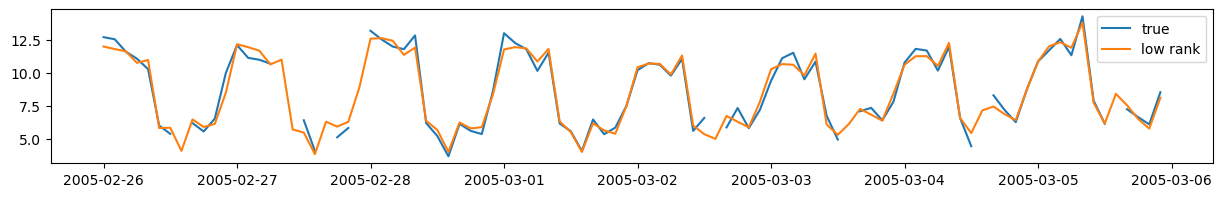

In [36]:
plt.figure(figsize=(15, 2))
plt.plot(df_siberia_equilibrate_2hourly['2005-02-26':'2005-03-05'], label='true')
plt.plot(df_siberia_equilibrate_2hourly_low_rank['2005-02-26':'2005-03-05'], label='low rank')
plt.legend()

In [39]:
# Chercher ce qui marche le mieux entre interpolation linéaire et low rank
# Chercher les hyperparamètres pour l'interpolation low rank

In [ ]:
# 5 fold cross validation

In [111]:
data = df_siberia_equilibrate_2hourly.reset_index().dropna()#.reset_index(drop=True)
n = len(data)
shuffled_indices = list(np.random.choice(data.index[1:-1], size=n-2, replace=False))
empty_rows = pd.DataFrame(columns=['tec'], index=df_siberia_equilibrate_2hourly [np.array(df_siberia_equilibrate_2hourly.isna())].index)
data = data.set_index('datetime')
data = pd.concat([data, empty_rows])
data = data.sort_index().reset_index().iloc[:-1, :] # to remove the last nan
data

/tmp/ipykernel_3059/3473864939.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, empty_rows])


,datetime,tec
0,2003-01-01 00:00:00,13.500000
1,2003-01-01 02:00:00,16.748276
2,2003-01-01 04:00:00,14.146154
3,2003-01-01 06:00:00,10.366667
4,2003-01-01 08:00:00,NaN
...,...,...
13147,2005-12-31 14:00:00,4.200000
13148,2005-12-31 16:00:00,5.057143
13149,2005-12-31 18:00:00,NaN
13150,2005-12-31 20:00:00,5.081818


In [116]:
mse_linear = []
mse_low_rank = {}
for K in [3, 6, 12, 24, 36, 48]:
    mse_low_rank[K] = []

for i in tqdm(range(1)):#5)):
    test_indices = shuffled_indices[i*(n-2)//5:(i+1)*(n-2)//5]
    
    data_linear = data.copy()
    data_linear.loc[test_indices, 'tec'] = np.nan
    data_linear = data_linear.set_index('datetime').interpolate(method='linear')
    data_linear = data_linear.reset_index()
    mse_linear.append(mean_squared_error(data.loc[test_indices, 'tec'], data_linear.loc[test_indices, 'tec']))

    for K in [3, 6, 12, 24, 36, 48]:
        data_low_rank = data.copy()
        data_low_rank.loc[test_indices, 'tec'] = np.nan
        X = create_trajectory_matrix(data_low_rank['tec'].to_numpy(), 84)
        W = (~np.isnan(X)).astype(int)
        X = np.nan_to_num(X)
        estimated_trajectory_matrix = low_rank_interpolate(X, W, K) # keep first K singular values 
        data_low_rank = pd.DataFrame(recover_time_series(estimated_trajectory_matrix), columns=['tec'], index=data['datetime']).reset_index()
        mse_low_rank[K].append(mean_squared_error(data.loc[test_indices, 'tec'], data_low_rank.loc[test_indices, 'tec']))
    
print('Linear interpolation MSE:', np.mean(mse_linear), mse_linear)
for K in [3, 6, 12, 24, 36, 48]:
    print(f'Low rank interpolation MSE, K={K}:', np.mean(mse_low_rank[K]), mse_low_rank[K])


  0%|          | 0/1 [00:00<?, ?it/s]
%|          | 0/100 [00:00<?, ?it/s]
%|          | 1/100 [00:00<00:57,  1.73it/s]
%|▏         | 2/100 [00:01<01:09,  1.41it/s]
%|▎         | 3/100 [00:02<01:08,  1.42it/s]
%|▍         | 4/100 [00:02<01:15,  1.28it/s]
%|▌         | 5/100 [00:03<01:04,  1.47it/s]
%|▌         | 6/100 [00:04<01:04,  1.46it/s]
%|▋         | 7/100 [00:05<01:07,  1.38it/s]
%|▊         | 8/100 [00:06<01:17,  1.19it/s]
%|▉         | 9/100 [00:06<01:15,  1.20it/s]
%|█         | 10/100 [00:07<01:13,  1.22it/s]
%|█         | 11/100 [00:08<01:09,  1.28it/s]
%|█▏        | 12/100 [00:09<01:12,  1.22it/s]
%|█▎        | 13/100 [00:09<01:02,  1.38it/s]
%|█▍        | 14/100 [00:10<01:01,  1.40it/s]
%|█▌        | 15/100 [00:11<01:00,  1.41it/s]
%|█▌        | 16/100 [00:12<00:59,  1.41it/s]
%|█▋        | 17/100 [00:12<01:01,  1.36it/s]
%|█▊        | 18/100 [00:13<00:56,  1.44it/s]
%|█▉        | 19/100 [00:14<01:01,  1.32it/s]
%|██        | 20/100 [00:14<00:59,  1.35it/s]
%|██        | 

Linear interpolation MSE: 5.844999662109984 [5.844999662109984]
Low rank interpolation MSE, K=3: 6.282696918451388 [6.282696918451388]
Low rank interpolation MSE, K=6: 4.04472047673771 [4.04472047673771]
Low rank interpolation MSE, K=12: 3.215977581511024 [3.215977581511024]
Low rank interpolation MSE, K=24: 2.5012091181319898 [2.5012091181319898]
Low rank interpolation MSE, K=36: 3.051663491731625 [3.051663491731625]
Low rank interpolation MSE, K=48: 3.9722896967499906 [3.9722896967499906]


In [ ]:
'''
Linear interpolation MSE: 5.844999662109984 [5.844999662109984]
Low rank interpolation MSE, K=3: 6.282696918451388 [6.282696918451388]
Low rank interpolation MSE, K=6: 4.04472047673771 [4.04472047673771]
Low rank interpolation MSE, K=12: 3.215977581511024 [3.215977581511024]
Low rank interpolation MSE, K=24: 2.5012091181319898 [2.5012091181319898]
Low rank interpolation MSE, K=36: 3.051663491731625 [3.051663491731625]
Low rank interpolation MSE, K=48: 3.9722896967499906 [3.9722896967499906]
'''

In [117]:
# Keep 24

In [ ]:
# Interpolation finale avec la bonne valeur pour K

In [118]:
X = create_trajectory_matrix(df_siberia_equilibrate_2hourly['tec'].to_numpy(), 84)
W = (~np.isnan(X)).astype(int)
X = np.nan_to_num(X)
estimated_trajectory_matrix = low_rank_interpolate(X, W, 24) # keep first 24 singular values 
df_siberia_equilibrate_2hourly_low_rank = pd.DataFrame(recover_time_series(estimated_trajectory_matrix), columns=['tec'], index=df_siberia_equilibrate_2hourly.index)

100%|██████████| 100/100 [01:26<00:00,  1.15it/s]


In [120]:
df_siberia_equilibrate_2hourly_linear

,datetime,tec
0,2003-01-01 00:00:00,13.500000
1,2003-01-01 02:00:00,16.748276
2,2003-01-01 04:00:00,14.146154
3,2003-01-01 06:00:00,10.366667
4,2003-01-01 08:00:00,7.562281
...,...,...
13148,2005-12-31 16:00:00,5.057143
13149,2005-12-31 18:00:00,5.069481
13150,2005-12-31 20:00:00,5.081818
13151,2005-12-31 22:00:00,7.966667


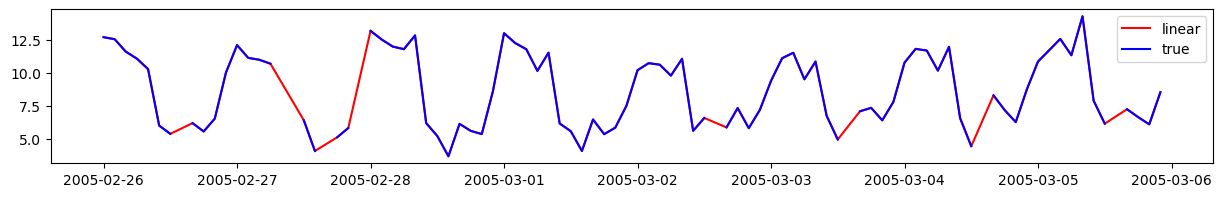

In [123]:
plt.figure(figsize=(15, 2))
plt.plot(df_siberia_equilibrate_2hourly_linear.set_index('datetime')['2005-02-26':'2005-03-05'], 'r-', label='linear')
plt.plot(df_siberia_equilibrate_2hourly['2005-02-26':'2005-03-05'], 'b-', label='true')
plt.legend()

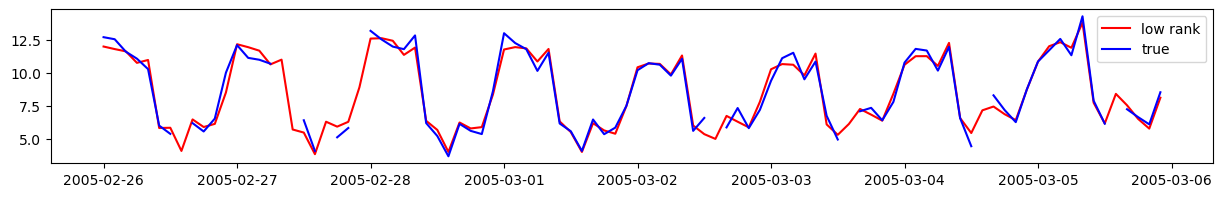

In [125]:
plt.figure(figsize=(15, 2))
plt.plot(df_siberia_equilibrate_2hourly_low_rank['2005-02-26':'2005-03-05'], 'r-', label='low rank')
plt.plot(df_siberia_equilibrate_2hourly['2005-02-26':'2005-03-05'], 'b-', label='true')
plt.legend()

In [127]:
# data = data.set_index('datetime')
# data_linear = data_linear.set_index('datetime')
# data_low_rank = data_low_rank.set_index('datetime')

In [128]:
# plt.figure(figsize=(15, 2))
# plt.plot(data_linear['2005-02-26':'2005-03-05'], 'r-', label='linear')
# plt.plot(data['2005-02-26':'2005-03-05'], 'b-', label='true')
# plt.legend()

In [129]:
# plt.figure(figsize=(15, 2))
# plt.plot(data_low_rank['2005-02-26':'2005-03-05'], 'r-', label='low_rank')
# plt.plot(data['2005-02-26':'2005-03-05'], 'b-', label='true')
# plt.legend()

In [131]:
# Prédire février 2005 et mars 2005.
# Entraîner de février 2003 à janvien 2005
df_siberia_equilibrate_2hourly_low_rank = df_siberia_equilibrate_2hourly_low_rank.reset_index()
train = df_siberia_equilibrate_2hourly_low_rank [(df_siberia_equilibrate_2hourly_low_rank['datetime'] >= '2003-02-25') & (df_siberia_equilibrate_2hourly_low_rank['datetime'] < '2005-02-25')] 
test = df_siberia_equilibrate_2hourly_low_rank [(df_siberia_equilibrate_2hourly_low_rank['datetime'] >= '2005-02-25') & (df_siberia_equilibrate_2hourly_low_rank['datetime'] < '2005-03-06')] 

In [132]:
train = train.set_index('datetime')
test = test.set_index('datetime')

In [133]:
train

,tec
datetime,
2003-02-25 00:00:00,20.149162
2003-02-25 02:00:00,20.288336
2003-02-25 04:00:00,15.739991
2003-02-25 06:00:00,17.016093
2003-02-25 08:00:00,13.898905
...,...
2005-02-24 14:00:00,4.395923
2005-02-24 16:00:00,6.607847
2005-02-24 18:00:00,5.749152


In [134]:
test

,tec
datetime,
2005-02-25 00:00:00,11.939442
2005-02-25 02:00:00,11.743277
2005-02-25 04:00:00,11.651925
2005-02-25 06:00:00,10.878801
2005-02-25 08:00:00,10.946793
...,...
2005-03-05 14:00:00,8.402668
2005-03-05 16:00:00,7.545068
2005-03-05 18:00:00,6.515836


### SARIMA

In [135]:
def sarimax_grid_search(data, p_range, d_range, q_range, P_range, D_range, Q_range):
    """
    Perform grid search over SARIMAX parameters (p, d, q) and (P, D, Q).
    
    Parameters:
    -----------
    data : array-like
        Time series data to fit
    p_range : list
        Range of p values to test
    d_range : list
        Range of d values to test
    q_range : list
        Range of q values to test
    P_range : list
        Range of P values to test
    D_range : list
        Range of D values to test
    Q_range : list
        Range of Q values to test
        
    Returns:
    --------
    results_df : pandas DataFrame
        DataFrame containing results for each parameter combination
    best_params : list
        [(p, d, q), (P, D, Q)] combination with lowest AIC
    """
    
    # Create all possible combinations of parameters
    pdqPDQ = list(itertools.product(p_range, d_range, q_range, P_range, D_range, Q_range))
    
    # Initialize results storage
    results = []
    
    # Grid search
    for param in tqdm(pdqPDQ):
        try:
            model = SARIMAX(data,
                            order=(param[0], param[1], param[2]),
                            seasonal_order=(param[3], param[4], param[5], 12))
            model_fit = model.fit(disp=False)
            
            # Store results
            results.append({
                'p': param[0],
                'd': param[1],
                'q': param[2],
                'P': param[3],
                'D': param[4],
                'Q': param[5],
                'aic': model_fit.aic,
                'bic': model_fit.bic,
                'hqic': model_fit.hqic,
                'converged': model_fit.mle_retvals['converged']
            })
            
        except Exception as e:
            results.append({
                'p': param[0],
                'd': param[1],
                'q': param[2],
                'P': param[3],
                'D': param[4],
                'Q': param[5],
                'aic': None,
                'bic': None,
                'hqic': None,
                'converged': False,
                'error': str(e)
            })
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Find best parameters (based on AIC)
    best_params = None
    if not results_df['aic'].isna().all():
        best_idx = results_df['aic'].idxmin()
        best_params = (
            results_df.loc[best_idx, 'p'],
            results_df.loc[best_idx, 'd'],
            results_df.loc[best_idx, 'q'],
            results_df.loc[best_idx, 'P'],
            results_df.loc[best_idx, 'D'],
            results_df.loc[best_idx, 'Q']
        )
    
    return results_df, best_params

In [136]:
# Define parameter ranges to test
p_range = list(range(0, 3))
d_range = list(range(0, 2))
q_range = list(range(0, 3))
P_range = list(range(0, 3))
D_range = list(range(0, 2))
Q_range = list(range(0, 3))

# Perform grid search
results_df, best_params = sarimax_grid_search(train, p_range, d_range, q_range, P_range, D_range, Q_range)

# Print results
print("\nTop 5 models by AIC:")
print(results_df.sort_values('aic').head())

print("\nBest parameters (p,d,q), (P,D,Q):", best_params)

100%|██████████| 324/324 [3:02:11<00:00, 33.74s/it]   


Top 5 models by AIC:
     p  d  q  P  D  Q          aic          bic         hqic  converged error
265  2  0  2  2  0  1  2726.529111  2783.163671  2745.825100      False   NaN
269  2  0  2  2  1  2  2788.077875  2851.779436  2809.783148      False   NaN
267  2  0  2  2  1  0  2829.806332  2879.351990  2846.688211       True   NaN
262  2  0  2  1  1  1  2831.563785  2881.109443  2848.445665       True   NaN
268  2  0  2  2  1  1  2833.322434  2889.946044  2852.616011       True   NaN

Best parameters (p,d,q), (P,D,Q): (np.int64(2), np.int64(0), np.int64(2), np.int64(2), np.int64(0), np.int64(1))


In [137]:
'''
100%|██████████| 324/324 [3:02:11<00:00, 33.74s/it]   


Top 5 models by AIC:
     p  d  q  P  D  Q          aic          bic         hqic  converged error
265  2  0  2  2  0  1  2726.529111  2783.163671  2745.825100      False   NaN
269  2  0  2  2  1  2  2788.077875  2851.779436  2809.783148      False   NaN
267  2  0  2  2  1  0  2829.806332  2879.351990  2846.688211       True   NaN
262  2  0  2  1  1  1  2831.563785  2881.109443  2848.445665       True   NaN
268  2  0  2  2  1  1  2833.322434  2889.946044  2852.616011       True   NaN

Best parameters (p,d,q), (P,D,Q): (np.int64(2), np.int64(0), np.int64(2), np.int64(2), np.int64(0), np.int64(1))
'''

'\n100%|██████████| 324/324 [3:02:11<00:00, 33.74s/it]   \n\n\nTop 5 models by AIC:\n     p  d  q  P  D  Q          aic          bic         hqic  converged error\n265  2  0  2  2  0  1  2726.529111  2783.163671  2745.825100      False   NaN\n269  2  0  2  2  1  2  2788.077875  2851.779436  2809.783148      False   NaN\n267  2  0  2  2  1  0  2829.806332  2879.351990  2846.688211       True   NaN\n262  2  0  2  1  1  1  2831.563785  2881.109443  2848.445665       True   NaN\n268  2  0  2  2  1  1  2833.322434  2889.946044  2852.616011       True   NaN\n\nBest parameters (p,d,q), (P,D,Q): (np.int64(2), np.int64(0), np.int64(2), np.int64(2), np.int64(0), np.int64(1))\n'

In [139]:
results_df.sort_values('aic').head(10)

,p,d,q,P,D,Q,aic,bic,hqic,converged,error
265,2,0,2,2,0,1,2726.529111,2783.163671,2745.825100,False,NaN
269,2,0,2,2,1,2,2788.077875,2851.779436,2809.783148,False,NaN
267,2,0,2,2,1,0,2829.806332,2879.351990,2846.688211,True,NaN
262,2,0,2,1,1,1,2831.563785,2881.109443,2848.445665,True,NaN
268,2,0,2,2,1,1,2833.322434,2889.946044,2852.616011,True,NaN
263,2,0,2,1,1,2,2833.385791,2890.009401,2852.679368,True,NaN
264,2,0,2,2,0,0,2839.770955,2889.326195,2856.654945,False,NaN
261,2,0,2,1,1,0,2888.025679,2930.493387,2902.495862,True,NaN
266,2,0,2,2,0,2,3063.223239,3126.937120,3084.931226,False,NaN
323,2,1,2,2,1,2,3098.082176,3161.782709,3119.787223,False,NaN


In [140]:
# Fit model with best parameters
best_model = SARIMAX(train, order=best_params[:3], seasonal_order=(*best_params[3:], 12)).fit(disp=False)
print("\nBest model summary:")
print(best_model.summary().tables[1])


Best model summary:
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9171      0.003    687.744      0.000       1.912       1.923
ar.L2         -0.9775      0.003   -351.029      0.000      -0.983      -0.972
ma.L1         -0.5629      0.006    -91.625      0.000      -0.575      -0.551
ma.L2          0.3878      0.007     53.095      0.000       0.373       0.402
ar.S.L12       1.7507      0.006    286.876      0.000       1.739       1.763
ar.S.L24      -0.7593      0.006   -122.082      0.000      -0.772      -0.747
ma.S.L12       0.0839      0.011      7.610      0.000       0.062       0.106
sigma2         0.0788      0.001    111.155      0.000       0.077       0.080


In [146]:
best_model.bic

np.float64(2783.163671469569)

In [143]:
predict = best_model.forecast(steps=216)
predict

2005-02-25 00:00:00    11.893224
2005-02-25 02:00:00    11.696810
2005-02-25 04:00:00    11.652117
2005-02-25 06:00:00    10.929999
2005-02-25 08:00:00    10.960796
                         ...    
2005-03-14 14:00:00     1.922028
2005-03-14 16:00:00     2.979067
2005-03-14 18:00:00     2.341558
2005-03-14 20:00:00     2.267047
2005-03-14 22:00:00     3.519963
Freq: 2h, Name: predicted_mean, Length: 216, dtype: float64

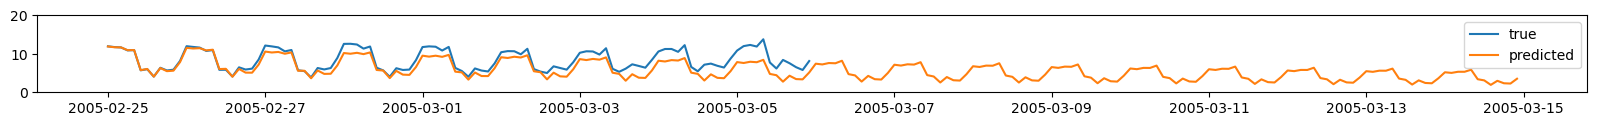

In [144]:
plt.figure(figsize=(20, 1))
plt.ylim(0, 20)
plt.plot(test, label='true')
plt.plot(predict, label='predicted')
plt.legend()

In [147]:
# Fit model with best parameters
best_model = SARIMAX(train, order=(2, 0, 2), seasonal_order=(2, 1, 2, 12)).fit(disp=False)
print("\nBest model summary:")
print(best_model.summary().tables[1])


Best model summary:
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8954      0.003    617.232      0.000       1.889       1.901
ar.L2         -0.9555      0.003   -310.914      0.000      -0.962      -0.950
ma.L1         -0.5588      0.006    -86.940      0.000      -0.571      -0.546
ma.L2          0.3968      0.008     52.721      0.000       0.382       0.412
ar.S.L12      -0.2118      0.018    -11.792      0.000      -0.247      -0.177
ar.S.L24       0.6770      0.015     46.226      0.000       0.648       0.706
ma.S.L12       1.0679      0.020     54.656      0.000       1.030       1.106
ma.S.L24       0.1492      0.011     14.007      0.000       0.128       0.170
sigma2         0.0800      0.001    113.258      0.000       0.079       0.081


In [148]:
best_model.bic

np.float64(2851.779435654979)

In [152]:
predict = best_model.forecast(steps=108)
predict

2005-02-25 00:00:00    11.926541
2005-02-25 02:00:00    11.712741
2005-02-25 04:00:00    11.657146
2005-02-25 06:00:00    10.918931
2005-02-25 08:00:00    10.947780
                         ...    
2005-03-05 14:00:00     3.456535
2005-03-05 16:00:00     5.590072
2005-03-05 18:00:00     4.522124
2005-03-05 20:00:00     4.506499
2005-03-05 22:00:00     6.743716
Freq: 2h, Name: predicted_mean, Length: 108, dtype: float64

In [156]:
np.mean(train['2004-02-25':'2004-03-06'])

np.float64(8.901079315923091)

In [158]:
np.mean(train['2005-02-18':'2005-02-28'])

np.float64(9.280507999498482)

In [154]:
np.mean(test)

np.float64(8.438554575089622)

In [153]:
np.mean(predict)

np.float64(7.535086111296169)

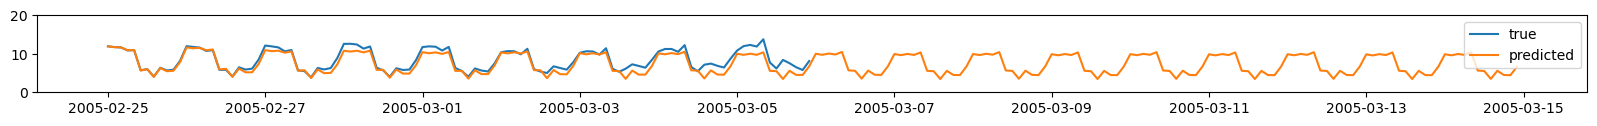

In [150]:
plt.figure(figsize=(20, 1))
plt.ylim(0, 20)
plt.plot(test, label='true')
plt.plot(predict, label='predicted')
plt.legend()

In [159]:
# Fit model with best parameters
best_model = SARIMAX(train, order=(2, 0, 2), seasonal_order=(2, 1, 0, 12)).fit(disp=False)
print("\nBest model summary:")
print(best_model.summary().tables[1])


Best model summary:
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8962      0.003    635.096      0.000       1.890       1.902
ar.L2         -0.9567      0.003   -321.799      0.000      -0.962      -0.951
ma.L1         -0.5650      0.006    -89.330      0.000      -0.577      -0.553
ma.L2          0.3969      0.007     53.388      0.000       0.382       0.411
ar.S.L12       0.8450      0.008    100.755      0.000       0.829       0.861
ar.S.L24      -0.0845      0.009     -9.842      0.000      -0.101      -0.068
sigma2         0.0806      0.001    114.469      0.000       0.079       0.082


In [160]:
best_model.bic

np.float64(2879.351990282224)

In [197]:
predict = best_model.forecast(steps=84)
predict

2005-02-25 00:00:00    11.941243
2005-02-25 02:00:00    11.746816
2005-02-25 04:00:00    11.703863
2005-02-25 06:00:00    10.979877
2005-02-25 08:00:00    11.012951
                         ...    
2005-03-03 14:00:00     3.587318
2005-03-03 16:00:00     5.618531
2005-03-03 18:00:00     4.610584
2005-03-03 20:00:00     4.567490
2005-03-03 22:00:00     6.787990
Freq: 2h, Name: predicted_mean, Length: 84, dtype: float64

In [195]:
np.mean(train['2004-02-25':'2004-03-05'])

np.float64(8.742668129099782)

In [175]:
np.mean(train['2005-02-18':'2005-02-28'])

np.float64(9.280507999498482)

In [199]:
np.mean(test.iloc[:84])

np.float64(8.283586618783216)

In [198]:
np.mean(predict)

np.float64(7.682387407633502)

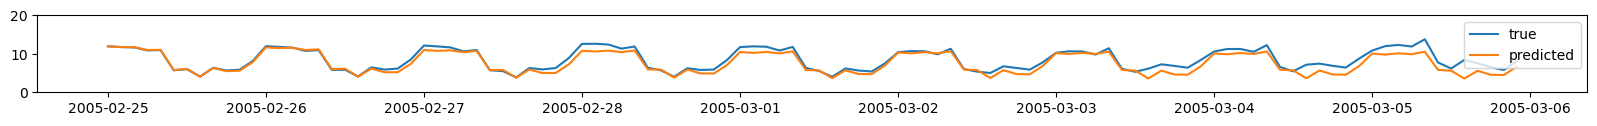

In [178]:
plt.figure(figsize=(20, 1))
plt.ylim(0, 20)
plt.plot(test, label='true')
plt.plot(predict, label='predicted')
plt.legend()

In [194]:
np.mean(best_model.resid)

np.float64(0.017292749868788617)

In [206]:
# les premières observations ont des résidus énormes, peut-être qu'il faut centrer avant et décentrer après

(array([2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 2.000e+00,
        3.000e+00, 3.000e+00, 6.000e+00, 5.000e+00, 8.000e+00, 7.000e+00,
        5.000e+00, 1.100e+01, 2.000e+01, 3.700e+01, 5.800e+01, 6.500e+01,
        1.110e+02, 1.530e+02, 3.000e+02, 5.450e+02, 9.280e+02, 1.373e+03,
        1.726e+03, 1.371e+03, 8.580e+02, 4.750e+02, 2.580e+02, 1.430e+02,
        7.100e+01, 6.100e+01, 3.400e+01, 3.400e+01, 1.600e+01, 1.600e+01,
        1.300e+01, 5.000e+00, 6.000e+00, 8.000e+00, 2.000e+00, 3.000e+00,
        2.000e+00, 1.000e+00, 2.000e+00, 3.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([-2.20000619, -2.10980524, -2.01960429, -1.92940334, -1.83920238,
        -1.74900143, -1.65880048, -1.56859953, -1.47839857, -1.38819762,
        -1.29799667, -1.20779571, -1.11759476, -1.02739381, -0.93719286,
        -0.8469919 , -0.75679095, -0.66659   , -0.57638905, -0.48618809,
        -0.39598714, -0.30578619, -0.21558523, -0.12538428, -0.03518333,
         0.

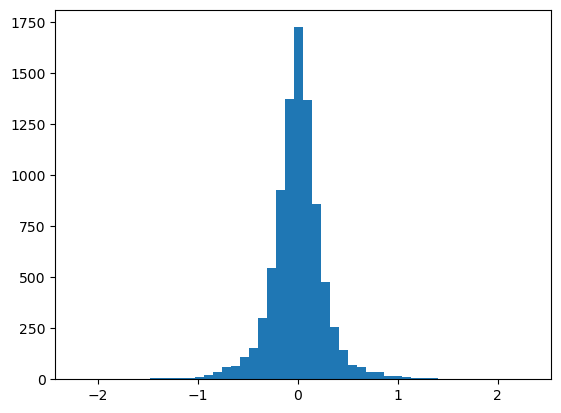

In [205]:
plt.hist(best_model.resid[20:], bins=50)

### LSTM

In [12]:
train = df_siberia_equilibrate_2hourly_low_rank [(df_siberia_equilibrate_2hourly_low_rank['datetime'] >= '2003-02-25') & (df_siberia_equilibrate_2hourly_low_rank['datetime'] < '2005-02-25')] 
test2 = df_siberia_equilibrate_2hourly_low_rank [(df_siberia_equilibrate_2hourly_low_rank['datetime'] >= '2005-02-20') & (df_siberia_equilibrate_2hourly_low_rank['datetime'] < '2005-03-06')] 

In [13]:
train = train.set_index('datetime')
test2 = test2.set_index('datetime')
sequence_length = 50
test2 = test2[len(test2) - len(test) - sequence_length:]

In [14]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train)

sequence_length = 50
X_train, y_train = [], []
for i in range(len(scaled_train) - sequence_length):
    X_train.append(scaled_train[i:i + sequence_length])
    y_train.append(scaled_train[i + sequence_length])

X_train = np.array(X_train)
y_train = np.array(y_train)

In [38]:
num_lstm_layers = 2
dropout_rate = 0.2
batch_size = 48
epochs = 500
validation_split = 0.05
input_dim = 1
output_dim = 1

model = Sequential()

model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(sequence_length, input_dim)))
model.add(Dropout(dropout_rate))

model.add(LSTM(units=50, activation='relu'))
model.add(Dropout(dropout_rate))

model.add(Dense(units=output_dim, activation='linear'))

model.compile(optimizer='Adam', loss='mae', metrics=['mae'])

model.summary()

history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=validation_split,
    verbose=1
)

2024-12-23 10:08:51.006876: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
173/173 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 0.0839 - mae: 0.0839 - val_loss: 0.0518 - val_mae: 0.0518
Epoch 2/500
173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.0599 - mae: 0.0599 - val_loss: 0.0485 - val_mae: 0.0485
Epoch 3/500
173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.0589 - mae: 0.0589 - val_loss: 0.0479 - val_mae: 0.0479
Epoch 4/500
173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.0574 - mae: 0.0574 - val_loss: 0.0437 - val_mae: 0.0437
Epoch 5/500
173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 0.0599 - mae: 0.0599 - val_loss: 0.0531 - val_mae: 0.0531
Epoch 6/500
173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.0605 - mae: 0.0605 - val_loss: 0.0492 - val_mae: 0.0492
Epoch 7/500
173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 0.0584 - mae: 0.0584 - val_loss: 0.0495 - val_mae: 0.0495
Epoch 8/500
173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.0560 - mae: 0.0560 - val_loss: 0.0494 - val_mae: 0.0494
Epoch 9/500
173/173 ━━━━━━━━━━━━━━━━━━━

In [62]:
model.save('lstm/lstm_model.keras')

In [35]:
lstm_model = load_model('lstm/lstm_model.keras')

In [21]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_test = scaler.fit_transform(test2)

sequence_length = 50
X_test, y_test = [], []
for i in range(len(scaled_test) - sequence_length):
    X_test.append(scaled_test[i:i + sequence_length])
    y_test.append(scaled_test[i + sequence_length])

X_test = np.array(X_test)
y_test = np.array(y_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1391 - mae: 0.1391
Loss on test data: 0.14032581448554993
MAE on test data: 0.14032581448554993


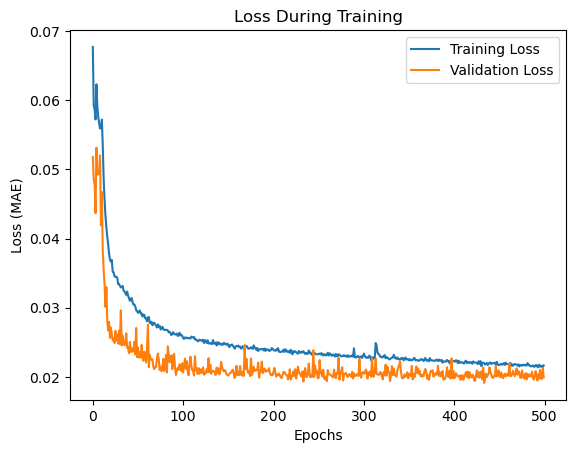

In [116]:
# Visualisation sur le dataset de test
loss, mae = model.evaluate(X_test, y_test, batch_size=batch_size)
print(f"Loss on test data: {loss}")
print(f"MAE on test data: {mae}")

# Visualisation de l'apprentissage
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss (MAE)')
plt.legend()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


RMSE of the LSTM model 6.7817073
Correlation of the LSTM model 0.77553884890125


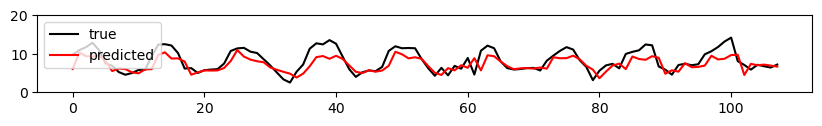

In [57]:
unscaled_lstm_prediction = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(unscaled_lstm_prediction)

unscaled_y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
plt.figure(figsize=(10, 1))
plt.ylim(0, 20)
plt.plot(unscaled_y_test, label='true', color='black')
plt.plot(lstm_predictions, label='predicted', color='red')
plt.legend()

lstm_rmse = np.sqrt(np.mean(unscaled_seq_prediction - lstm_predictions)**2)
print('RMSE of the LSTM model', lstm_rmse)

lstm_correlation = correlation(lstm_predictions, unscaled_y_test)
print('Correlation of the LSTM model', lstm_correlation)

### Seq2Seq

In [ ]:
learning_rate = 0.01
lambda_l2_reg = 0.003
hidden_dim = 64
num_lstm_layers = 1  
gradient_clipping = 2.5
num_input_signals = 1
num_output_signals = 1

model = Sequential()

model.add(LSTM(
    units=hidden_dim, 
    activation='relu', 
    input_shape=(X_train.shape[1], num_input_signals), 
    return_sequences=False, 
    kernel_regularizer=tf.keras.regularizers.l2(lambda_l2_reg)
))

model.add(Dense(units=num_output_signals))

optimizer = Adam(learning_rate=learning_rate, clipvalue=gradient_clipping)

model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

model.summary()

history = model.fit(
    X_train, y_train,
    epochs=1500,
    batch_size=48,
    validation_split=0.2,
    verbose=1,
)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1500
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0094 - mae: 0.0697 - val_loss: 0.0079 - val_mae: 0.0747
Epoch 2/1500
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0057 - mae: 0.0571 - val_loss: 0.0055 - val_mae: 0.0618
Epoch 3/1500
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0050 - mae: 0.0539 - val_loss: 0.0036 - val_mae: 0.0435
Epoch 4/1500
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0037 - mae: 0.0424 - val_loss: 0.0060 - val_mae: 0.0637
Epoch 5/1500
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0027 - mae: 0.0358 - val_loss: 0.0018 - val_mae: 0.0306
Epoch 6/1500
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0025 - mae: 0.0354 - val_loss: 0.0017 - val_mae: 0.0292
Epoch 7/1500
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0023 - mae: 0.0329 - val_loss: 0.0031 - val_mae: 0.0441
Epoch 8/1500
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0021 - mae: 0.0328 - val_loss: 0.0020 - val_mae: 0.0326
Epoch 9/1500
146/146 ━━━━━━━━━━━

In [ ]:
model.save('seq2seq/seq2seq_model.keras')

In [27]:
seq2seq_model = load_model('seq2seq/seq2seq_model.keras')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
RMSE of the Seq2seq model 7.5917516
Correlation of the Seq2seq model 0.859081610584248


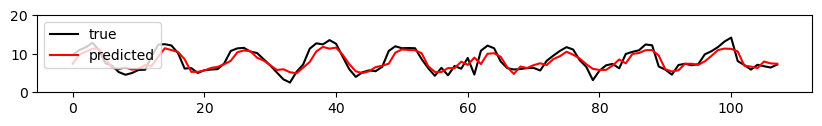

In [55]:
unscaled_seq_prediction = seq2seq_model.predict(X_test)
seq2seq_predictions = scaler.inverse_transform(unscaled_seq_prediction)

unscaled_y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
plt.figure(figsize=(10, 1))
plt.ylim(0, 20)
plt.plot(unscaled_y_test, label='true', color='black')
plt.plot(seq2seq_predictions, label='predicted', color='red')
plt.legend()

seq_rmse = np.sqrt(np.mean(unscaled_seq_prediction - seq2seq_predictions)**2)
print('RMSE of the Seq2seq model', seq_rmse)

seq_correlation = correlation(seq2seq_predictions, unscaled_y_test)
print('Correlation of the Seq2seq model', seq_correlation)